# Useful to test syntaxes, data, structure before adding them to scripts

In [21]:
import warnings
warnings.simplefilter(action='ignore')

import functools
import argparse
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from torch.utils.tensorboard import SummaryWriter
from scipy.stats import gamma
import os
import time
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchnet as tnt
from sklearn.neighbors import NearestNeighbors
import gc

import torch.nn as nn
from scipy.special import digamma, polygamma

import matplotlib
# Weird behavior: loading twice in cell appears to remove an elsewise occuring error.
for i in range(2):
    try:
        matplotlib.use('TkAgg')  # rerun this cell if an error occurs.
    except:
        print("!")
import matplotlib.pyplot as plt


import pickle
from torch_scatter import scatter_max, scatter_mean

print(torch.cuda.is_available())
np.random.seed(42)
torch.cuda.empty_cache()
print("Everything is imported")

False
Everything is imported


In [22]:
%matplotlib inline
import matplotlib.colors as clr

In [5]:
from osgeo import gdal
import sys
import os
sys.path.append("/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/")
from config import args
from utils.useful_functions import create_new_experiment_folder, print_stats

Dataset folder in use: /home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/data/
Arguments were imported in PROD mode


In [6]:
# work with previous inference results
args.stats_path = "/home/CGaydon/Documents/LIDAR PAC/plot_vegetation_coverage/experiments/RESULTS_3_strata/only_stratum/DEV/inference/2021-06-08_17h51m52s/"
tiff_folder_path = os.path.join(args.stats_path, "img/rasters/004000715-5-18/")
input_file_list = os.path.join(tiff_folder_path, "rasters_paths.txt")

# Create fake TIF and merge them with all options and NODATA

In [88]:
from osgeo import osr
from osgeo import gdal

nb_channels_scores = 3
nb_channels = 2 * nb_channels_scores  # one for scores doubled with weights 
a = np.clip(np.random.random((nb_channels, 32, 32))+0.4, 0,1)
a[nb_channels_scores:] = 1
b = np.random.random((nb_channels, 32, 32))
b[nb_channels_scores:] = 1

# We set Lambert 93 projection
srs = osr.SpatialReference()
srs.ImportFromEPSG(2154)
proj = srs.ExportToWkt()
geotransformation = [
    [
        924462.2800000001,  # x coordinate upper_left of upper_left pixel
        0.6199999999989814,  # pixel width - not 0.625 ?? -> calculated with min/max of points !
        0,  # rotation
        6323318.64,  # same for y
        0,
        -0.6224999999976717,  # pixel height - can be negative to reverse !
    ],
    [
        924462.2800000001+8,  # x coordinate upper_left of upper_left pixel
        0.6199999999989814,  # pixel width - not 0.625 ?? -> calculated with min/max of points !
        0,  # rotation
        6323318.64+8,  # same for y
        0,
        -0.6224999999976717,  # pixel height - can be negative to reverse !
    ],
]  # from vscode

NODATAVALUE = np.nan

b[:,:,:3] = NODATAVALUE
a[:,-3:,:] = NODATAVALUE

for idx, data_array in enumerate([a, b]):
    print(idx)
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(2154)
    proj = srs.ExportToWkt()

    driver_tiff = gdal.GetDriverByName("GTiff")
    dst_ds = driver_tiff.Create(
        f"./temp_tif_merge_rasterio/test_{idx}.tif", 32, 32, nb_channels, gdal.GDT_Float32
    )
    dst_ds.SetGeoTransform(geotransformation[idx])
    dst_ds.SetProjection(proj)

    if nb_channels == 1:
        outband = dst_ds.GetRasterBand(1)
        outband.WriteArray(data_array)
        outband.SetNoDataValue(NODATAVALUE)
        outband = None
    else:
        for ch in range(nb_channels):
            outband = dst_ds.GetRasterBand(ch + 1)
            outband.WriteArray(data_array[ch])
            outband.SetNoDataValue(NODATAVALUE)
            outband = None

    dst_ds.FlushCache()  # write to file
    dst_ds = None

0
1


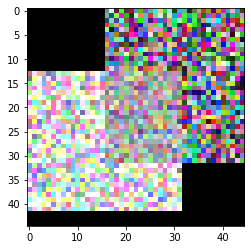

<AxesSubplot:>

In [14]:
# test merge with rasterio
import rasterio
import glob
from rasterio.merge import merge
from rasterio.plot import show

# https://automating-gis-processes.github.io/CSC18/lessons/L6/raster-mosaic.html
# merge :; https://rasterio.readthedocs.io/en/latest/api/rasterio.merge.html


def weighted_sum(
    old_data, new_data, old_nodata, new_nodata, index=None, roff=None, coff=None
):
    """
    Input data is composed of rasters with C * 2 bands, where C is the number of score.
    A weighted sum is performed on both scores bands [0:C] and weights [C:] using weights.
    One then needs to divide scores by the values of weights.
    """

    weights_sum = np.zeros_like(old_data)
    n_score_channels = int(len(old_data) / 2)
    for band_idx in range(n_score_channels):  # for each score band
        w_idx = n_score_channels + band_idx
        # scale the score with weights, ignoring nodata in scores
        old_data[band_idx] = (
            old_data[band_idx] * old_data[w_idx] * (1 - old_nodata[band_idx])  # contrib is zero if nodata
        )
        new_data[band_idx] = (
            new_data[band_idx] * new_data[w_idx] * (1 - new_nodata[band_idx])  # contrib is zero if nodata
        )
        
        # scale the weights with themselves, ignoring nodata in scores
        w_idx = n_score_channels + band_idx 
        old_data[w_idx] = old_data[w_idx] * (1 - old_nodata[band_idx])  # contrib is zero if nodata
        new_data[w_idx] = new_data[w_idx] * (1 - new_nodata[band_idx])  # contrib is zero if nodata
        
    # set back to NoDataValue
    old_data[old_nodata] = np.nan
    new_data[new_nodata] = np.nan
        
    
    # sum everything
    out_data = np.nansum(
        [old_data, new_data], axis=0
    )  # nansum the two rasters -> (2*C,32,32) output
#     data_sum[np.isnan(data_sum)] = NODATAVALUE

    # we have to update the content of the input argument
    old_data[:] = out_data[:]  



a0 = f"./temp_tif_merge_rasterio/test_0.tif"
a1 = f"./temp_tif_merge_rasterio/test_1.tif"
dem_fps = [a0, a1]
src_files_to_mosaic = []
for fp in dem_fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

mosaic, out_trans = merge(src_files_to_mosaic, method=weighted_sum)

# average using weights
mosaic[:3] = mosaic[:3] / mosaic[3:]

show(mosaic[:3,:,:])

In [20]:
np.empty(18)

array([ 4.67860930e-310,  0.00000000e+000,  1.90032054e-165,
        3.78954807e-270,  7.01994014e-067, -1.05819076e+178,
        1.69326792e+001, -1.02655089e+155,  4.02434397e-226,
        8.54601156e-227,  1.18208647e-124,  7.07948134e-067,
        6.55882338e+287,  1.06933812e-295, -3.30290519e-219,
        8.24355457e+176, -4.28534641e+303, -4.68928047e+057])

In [15]:
out_trans

Affine(0.6199999999989814, 0.0, 924462.2800000001,
       0.0, -0.6224999999976717, 6323326.64)

In [18]:
?np.concatenate

In [99]:
# save to
out_fp = "./temp_tif_merge_rasterio/merged.tif"


# Copy the metadata
out_meta = src.meta.copy()

# Update the metadata
out_meta.update(
    {
        "driver": "GTiff",
        "height": mosaic.shape[1],
        "width": mosaic.shape[2],
        "transform": out_trans,
        #         "crs": "+proj=utm +zone=35 +ellps=GRS80 +units=m +no_defs ",
    }
)
with rasterio.open(out_fp, "w", **out_meta) as dest:
    dest.write(mosaic)

In [98]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': nan,
 'width': 45,
 'height': 45,
 'count': 6,
 'crs': CRS.from_epsg(2154),
 'transform': Affine(0.6199999999989814, 0.0, 924462.2800000001,
        0.0, -0.6224999999976717, 6323326.64)}